# Calcular el churn de clientes en empresa de telecomunicaciones
## Autor: Pablo Benayas
1. Objetivo: La empresa quiere predecir qué clientes no continuarán con la empresa el próximo mes. Para ello, varios datasets de Diciembre y Enero han sido entregados. 
2. Hoja de ruta:
    1. Fusionar los datasets por mes, definir la variables objetivo y pre-procesar los datos.
    2. Correr un modelo inicial y evaluar sus resultados
    3. Mejorar el modelo:
        1. Transformar las variables para mejorar su correlación con la objetivo.
        2. Añadir variables que puedan haber sido quitadas en el pre-proceso.
        3. Seleccionar las variables mas significativas.
    4. Correr modelos y evaluar resultados 
3. ¡Empecemos!

### Cargo las librerías que voy a usar

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import seaborn as sns
import matplotlib.pyplot  as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import naive_bayes
from datetime import datetime


from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
import matplotlib.pyplot  as plt

C:\Users\pablo\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.linear_model.logistic module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


## Cargo todos los datasets, especificando si son de Enero o Diciembre

In [2]:
clientes_diciembre=pd.read_csv('clientes_diciembre.csv', sep='|')
consumos_diciembre=pd.read_csv('consumos_diciembre.csv', sep='|')
financiacion_diciembre=pd.read_csv('financiacion_diciembre.csv', sep='|')
productos_diciembre=pd.read_csv('productos_diciembre.csv', sep='|') 

df=clientes_diciembre.merge(consumos_diciembre,on='id', how='left')
df=df.merge(financiacion_diciembre,on='id', how='left')
data_diciembre=df.merge(productos_diciembre,on='id', how='left') 


clientes_enero=pd.read_csv('clientes_enero.csv', sep='|')
consumos_enero=pd.read_csv('consumos_enero.csv', sep='|')
financiacion_enero=pd.read_csv('financiacion_enero.csv', sep='|')
productos_enero=pd.read_csv('productos_enero.csv', sep='|')

df=clientes_enero.merge(consumos_enero,on='id', how='left')
df=df.merge(financiacion_enero,on='id', how='left')
data_enero=df.merge(productos_enero,on='id', how='left') 

## Para evitar duplicar el proceso de limpieza. Voy a unir el dataset de Diciembre y Enero con el nuevo dataset 'data'.
#### Como medida preventiva, crearé una variable adicional 'Mes del dataset' que tendrá dos posible valores: Diciembre y Enero

In [3]:
data_diciembre['Mes del dataset']='Diciembre'
data_enero['Mes del dataset']='Enero'
data=pd.concat([data_diciembre, data_enero], axis=0)
data

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,financiacion,imp_financ,descuentos,conexion,vel_conexion,TV,Mes del dataset
0,1,63,216.028109,11/23/2018 08:48 AM,La Rioja,5,NaN,NaN,110,79,10897,12806,13751,NaN,NaN,NaN,FIBRA,50MB,tv-futbol,Diciembre
1,2,84,255.830842,08/22/2017 03:19 AM,Vizcaya,3,NaN,NaN,189,89,18657,6499,10862,NaN,NaN,SI,FIBRA,600MB,tv-futbol,Diciembre
2,3,66,135.768153,12/27/2001 01:50 PM,Albacete,4,NaN,NaN,129,30,15511,17013,16743,NaN,NaN,SI,ADSL,35MB,tv-futbol,Diciembre
3,4,69,255.658527,08/08/2015 10:53 AM,Lugo,4,NaN,NaN,51,52,12670,3393,6771,NaN,NaN,NaN,FIBRA,200MB,tv-familiar,Diciembre
4,5,25,22.302845,08/29/1997 02:19 AM,Tarragona,2,2.0,NaN,183,3,23756,18436,4485,NaN,NaN,NaN,ADSL,10MB,tv-futbol,Diciembre
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92706,99996,36,215.890326,04/09/2013 01:33 PM,Guadalajara,3,NaN,NaN,217,96,9059,7735,8823,NaN,NaN,NaN,ADSL,30MB,tv-futbol,Enero
92707,99997,68,285.890750,08/08/2003 11:57 PM,Asturias,5,NaN,NaN,168,99,9303,4798,3996,SI,14.616422,NaN,FIBRA,200MB,tv-futbol,Enero
92708,99998,20,383.167610,03/27/2013 08:07 PM,Álava,4,NaN,NaN,188,71,19018,1237,16720,NaN,NaN,NaN,ADSL,20MB,tv-futbol,Enero
92709,99999,53,53.301395,01/18/2020 02:30 AM,Sevilla,2,NaN,NaN,138,40,20264,10552,17637,NaN,NaN,NaN,FIBRA,50MB,tv-futbol,Enero


# Defino la variable objetivo:
### Quiero definir una variable que me especifique si un cliente continúa usando el servicio en Enero o no. 
### Para saber si el cliente continúa en Enero, simplemente hay que evaluar si el Id del cliente del dataset de Diciembre continúa apareciendo en el de Enero. En caso afirmativo, la persona continúa con la empresa y, en caso contrario, se ha dado de baja.
### La variable objetivo la voy a llamar '¿Abandona?' y tiene valor 1 cuando la persona deja de ser cliente y 0 cuando continúa.
##### Para el mes de Enero esta variable tendrá valor NA porque no podemos comprobar si el cliente abandonó en Febrero, ya que no se dispone del dataset

In [4]:
data['¿Abandona?']=data_diciembre.id.isin(data_enero.id).apply(lambda x: 0 if x else 1) 
data.loc[data['Mes del dataset']=='Enero','¿Abandona?']=np.nan
data.isnull().sum() 

id                      0
edad                    0
facturacion             0
antiguedad              0
provincia               0
num_lineas              0
num_dt             179047
incidencia         180955
num_llamad_ent          0
num_llamad_sal          0
mb_datos                0
seg_llamad_ent          0
seg_llamad_sal          0
financiacion       175140
imp_financ         175140
descuentos         148986
conexion                0
vel_conexion            0
TV                      0
Mes del dataset         0
¿Abandona?          92711
dtype: int64

###### Más adelante voy a eliminar variables en el preprocesado. Por tanto, hago una copia de seguridad con todas las variables

In [5]:
data.to_csv('full.csv') 

# Preprocesado

### Las variables que tienen muchos NAs van a ser eliminadas. 
### En su lugar, voy a crear una nueva variable 'number of NAs' que va a contar el número de NAs por fila.

###### Dado que los valores de Enero tienen un NA mas por defecto ('¿Abandona?'=NA), voy a restarle 1 a la vairable 'number of NAs'

In [6]:
data['number of NAs']=data.apply(lambda x: x.isnull().sum(), axis=1) 
data.loc[data['Mes del dataset']=='Enero','number of NAs']=data.loc[data['Mes del dataset']=='Enero','number of NAs'].apply(lambda x: x-1)                        

#### Elimino las varaibles con muchos NAs

In [7]:
data.drop(['num_dt','incidencia','financiacion','imp_financ',
                     'descuentos','id'], axis=1, inplace=True)
data.isnull().sum() 

edad                   0
facturacion            0
antiguedad             0
provincia              0
num_lineas             0
num_llamad_ent         0
num_llamad_sal         0
mb_datos               0
seg_llamad_ent         0
seg_llamad_sal         0
conexion               0
vel_conexion           0
TV                     0
Mes del dataset        0
¿Abandona?         92711
number of NAs          0
dtype: int64

In [8]:
data.dtypes

edad                 int64
facturacion        float64
antiguedad          object
provincia           object
num_lineas           int64
num_llamad_ent       int64
num_llamad_sal       int64
mb_datos             int64
seg_llamad_ent       int64
seg_llamad_sal       int64
conexion            object
vel_conexion        object
TV                  object
Mes del dataset     object
¿Abandona?         float64
number of NAs        int64
dtype: object

### Tenemos una variable con las fechas de alta de los clientes.
### Esta variable es leída como cadena de caracteres. Sin embargo, el objetivo es pasarla a numérica. Para ello, tenemos que hacer un paso intermedio convirtiéndola a formato fecha previamente.
### La transformación a formato fecha la hacemos con la función datetime.strptime(). Es importante recalcar que, para que la función haga la conversión, hay que correctamente especificar el formato de fecha que se está usando. En este caso:  '%m/%d/%Y %I:%M %p'.
### Una vez en formato fecha, le paso la función 'datetime.timestamp()' para realizar la conversión a numérico.

In [9]:
data['antiguedad'] = data.antiguedad.apply(lambda x: datetime.timestamp(datetime.strptime(x, '%m/%d/%Y %I:%M %p'))) 

### Número de valores únicos que tiene cada variable

In [10]:
pd.DataFrame(data.columns, index=data.columns).apply(lambda x: len(data[x[0]].unique()), axis=1)

edad                   68
facturacion        100522
antiguedad          99284
provincia              50
num_lineas              5
num_llamad_ent        251
num_llamad_sal        101
mb_datos            24985
seg_llamad_ent      19998
seg_llamad_sal      20001
conexion                2
vel_conexion           11
TV                      3
Mes del dataset         2
¿Abandona?              3
number of NAs           6
dtype: int64

Las variables con pocos valores únicos serán muy posiblemente tratadas como categóricas

### Las variables de tipo objeto son aquellas leídas como cadena de caracteres.

In [11]:
data.dtypes

edad                 int64
facturacion        float64
antiguedad         float64
provincia           object
num_lineas           int64
num_llamad_ent       int64
num_llamad_sal       int64
mb_datos             int64
seg_llamad_ent       int64
seg_llamad_sal       int64
conexion            object
vel_conexion        object
TV                  object
Mes del dataset     object
¿Abandona?         float64
number of NAs        int64
dtype: object

#### Más adelante, cuando tenga que hacer feature engineering, me vendrá bien saber la categoría que la función LabelEncoder ha asignado a cada uno de sus valores numéricos generados.
Pero primero, demuestro que LabelEncoder ordena los valores únicos alfabéticamente

In [12]:
ejemplo=pd.DataFrame({'col1':['dog','cat','dog','monkey','iguana','cat']})
transform1 = LabelEncoder() 
transform1.fit_transform(list(ejemplo['col1'].unique())) 
ejemplo['col2']=transform1.transform(ejemplo['col1'])
print('Como se puede observar el orden alfabético es respetado. \n "cat" recibe el valor más bajo (cero), y así sucesivamente.')
ejemplo

Como se puede observar el orden alfabético es respetado. 
 "cat" recibe el valor más bajo (cero), y así sucesivamente.


,col1,col2
0,dog,1
1,cat,0
2,dog,1
3,monkey,3
4,iguana,2
5,cat,0


##### Dado que LabelEncoder ordena los valores únicos alfabéticamente y los pasa a númerico, voy a crear una leyenda que relaciona el número de LabelEncoder con su categoría de origen

In [13]:
def leyenda_valores_LabelEncoder(lista_de_variables):
    dicc={}
    for col in lista_de_variables:
        values=list(data[str(col)].unique())  
        values.sort()
        dicc['values_'+str(col)]=pd.DataFrame({'values':values, 
                                 'LabelEncoder equivalent':[i for i in range(len(values))]})
    return dicc

###### Confirmo que la función no da error y guardo los valores originales de las variables categóricas en el diccionario que la función 'leyenda_valores_LabelEncoder()' crea

In [14]:
categVars=list(data.columns[list(data.apply(lambda x: len(x.unique())<13))]) 
leyenda_LabelEncoder=leyenda_valores_LabelEncoder(categVars) 

In [15]:
leyenda_LabelEncoder['values_TV']

,values,LabelEncoder equivalent
0,tv-familiar,0
1,tv-futbol,1
2,tv-total,2


###  Convierto las variables categóricas en numericas con LabelEncoder()
###### Importante: no creo dummies porque más adelante, al hacer feature engineering, me producirá problemas de multicolinearidad. (Por este motivo, dejo las líneas de código de la creación de dummies como comentario)

In [16]:
# LabelEncoder() & dummies
dictLabelEncoder={}
dummies={}
categVars=data.loc[:,['num_lineas','TV']]

transform1 = LabelEncoder()
for col in categVars:
    #labelEncoder
    transform1.fit_transform(list(data[col].unique())) 
        
    dictLabelEncoder[col]=transform1.transform(data[col])
    
#     #dummies
#     value_names_for_dummies=list(categVars[str(col)].unique())
#     for i in  range(len(value_names_for_dummies)):
#         dummies[str(col)+'_'+str(value_names_for_dummies[i])]=pd.get_dummies(categVars[str(col)]).iloc[:,i]         

data.loc[:,['num_lineas','TV']]=pd.DataFrame(dictLabelEncoder)
# dummies=pd.DataFrame(dummies)

# data=pd.concat([data, dummies.reindex(data.index)], axis=1) 

### Utilizo label encoder para las siguientes variables categóricas también.

In [17]:
transform1.fit_transform(list(data['provincia'].unique()))
data['provincia']=transform1.transform(data['provincia']) 

In [18]:
transform1.fit_transform(list(data['conexion'].unique()))
data['conexion']=transform1.transform(data['conexion']) 

### La variable 'vel_conexion' es de tipo objeto porque sus valores contienen los caracteres 'MB' al final.
### Sin embargo, esta variable debería ser tratada como numérica. Eliminando los dos últimos elementos de sus valores, estos pueden ser convertidos a formato numérico.

In [19]:
data['vel_conexion']=data.vel_conexion.apply(lambda x: float(x[:-2])) 

# Revisión final: 
    1) Ver que no hay variables de tipo objeto
    2) Ver que no hay NAs
    3) Pasar la función 'describe()' para confirmar que no hay valores atípicos

In [20]:
data.dtypes

edad                 int64
facturacion        float64
antiguedad         float64
provincia            int32
num_lineas           int64
num_llamad_ent       int64
num_llamad_sal       int64
mb_datos             int64
seg_llamad_ent       int64
seg_llamad_sal       int64
conexion             int32
vel_conexion       float64
TV                   int32
Mes del dataset     object
¿Abandona?         float64
number of NAs        int64
dtype: object

In [21]:
data.isnull().sum() 

edad                   0
facturacion            0
antiguedad             0
provincia              0
num_lineas             0
num_llamad_ent         0
num_llamad_sal         0
mb_datos               0
seg_llamad_ent         0
seg_llamad_sal         0
conexion               0
vel_conexion           0
TV                     0
Mes del dataset        0
¿Abandona?         92711
number of NAs          0
dtype: int64

In [22]:
data.describe()

,edad,facturacion,antiguedad,provincia,num_lineas,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,conexion,vel_conexion,TV,¿Abandona?,number of NAs
count,188178.000000,188178.000000,1.881780e+05,188178.000000,188178.000000,188178.000000,188178.000000,188178.000000,188178.000000,188178.000000,188178.000000,188178.000000,188178.000000,95467.000000,188178.000000
mean,51.445902,207.440105,1.191667e+09,24.512780,2.558344,124.960580,49.942060,12499.843850,9984.887548,10030.097652,0.497864,136.363868,0.794514,0.074214,4.566251
std,19.588371,111.291972,2.322174e+08,14.451853,1.086158,72.457194,29.163648,7228.701809,5768.944531,5774.962597,0.499997,179.157967,0.678040,0.262120,0.727050
min,18.000000,15.000439,7.889702e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000
25%,35.000000,111.370882,9.909848e+08,12.000000,2.000000,62.000000,25.000000,6205.000000,4983.000000,5032.000000,0.000000,20.000000,0.000000,0.000000,4.000000
50%,51.000000,206.927616,1.191034e+09,25.000000,3.000000,125.000000,50.000000,12496.000000,9981.000000,10029.000000,0.000000,35.000000,1.000000,0.000000,5.000000
75%,68.000000,304.388724,1.392490e+09,37.000000,3.000000,188.000000,75.000000,18764.000000,14974.000000,15020.000000,1.000000,200.000000,1.000000,0.000000,5.000000
max,85.000000,399.998433,1.580442e+09,49.000000,4.000000,250.000000,100.000000,25000.000000,20000.000000,20000.000000,1.000000,600.000000,2.000000,1.000000,5.000000


### Tras haber hecho una limpieza rápida de los datos, voy a tirar el primer modelo. 
### (Solo con Diciembre)

In [23]:
data_diciembre=data.loc[data['Mes del dataset']=='Diciembre',list(pd.DataFrame(data.columns).apply(lambda x: x[0] not in ['Mes del dataset'], axis=1))] 
restOfVars=data_diciembre.loc[:, list(pd.DataFrame(data_diciembre.columns).apply(lambda x: x[0] not in ['¿Abandona?'], axis=1))]  
target=data_diciembre['¿Abandona?']
data_diciembre=pd.concat([restOfVars, target.reindex(target.index)], axis=1) 
X, y = data_diciembre.iloc[:,:-1], data_diciembre.iloc[:,-1] 

scaler = MinMaxScaler()    
X=scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y) 
classifier = LogisticRegression().fit(X_train, y_train)
y_pred     = classifier.predict(X_test) 

In [24]:
## métricas

def saca_metricas(y1, y2): #y_real (y_test) and y_pred
    print('matriz de confusión')
    print(confusion_matrix(y1, y2))
    print('accuracy')
    print(accuracy_score(y1, y2))
    print('precision')
    print(precision_score(y1, y2))
    print('recall')
    print(recall_score(y1, y2))
    print('f1')
    print(f1_score(y1, y2))
    false_positive_rate, recall, thresholds = roc_curve(y1, y2)
    roc_auc = auc(false_positive_rate, recall)
    print('AUC')
    print(roc_auc)
    plt.plot(false_positive_rate, recall, 'b')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('AUC = %0.2f' % roc_auc)
    

matriz de confusión
[[22056    40]
 [ 1771     0]]
accuracy
0.9241211714920182
precision
0.0
recall
0.0
f1
0.0
AUC
0.4990948587979725


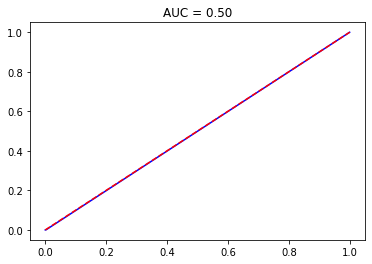

In [25]:
saca_metricas(y_test, y_pred)  

### Come se puede observar, el modelo tiene 92% de accuracy, a pesar de tener una precision y recall de 0%. Este fenómeno se debe a que en nuestra target '¿Abandona?', la inmensa mayoría de los clientes (más del 90%) continúan con la empresa y muy pocos se marchan.

### Por lo tanto, el modelo no es buen predictor. 

### ¿Que voy a hacer para mejorar el modelo?:
    1. 'Feature engineering' a las variables usadas. 
    2. Añadir las variables que quité al principio.
    3. Hacer selección de variables

### Observamos la correlación que tienen las actuales variables con la target.
### A excepción de la variable 'number of NAs', el resto de variables tienen una correlación extremadamente baja.
##### 'Mes del dataset' no esta incluida en la matriz correlaciones dado que sus valores son cadenas de caracteres

In [26]:
corr = abs(data.corr())
corr[['¿Abandona?']].sort_values(by = '¿Abandona?',ascending = False).style.background_gradient() 

,¿Abandona?
¿Abandona?,1
number of NAs,0.223008
provincia,0.00630453
num_llamad_ent,0.00612962
antiguedad,0.00314576
num_llamad_sal,0.00314091
edad,0.00286418
facturacion,0.00284625
TV,0.00264543
conexion,0.00254613


### Voy a usar la función 'proporciones_final()' para identificar patrones que los valores de las variables tienen con respecto a la objetivo

In [27]:
def proporciones_final(var,target,df):

    proporcion = pd.DataFrame()

    proporcion['%depositos'] = df[target].groupby(df[var]).mean()*100 
    proporcion['Conteo'] = df[target].groupby(df[var]).count() 
    proporcion= proporcion.round(3)   
    proporcion_filtered = proporcion[(proporcion['%depositos']>0) & (proporcion['Conteo']>10)]
        
    if len(proporcion_filtered)<100 and len(proporcion_filtered)>1:
        fig = plt.figure()
        ax = proporcion_filtered['Conteo'].plot(kind='bar',grid=True)
                
        ax2 = ax.twinx()
        ax2.plot(proporcion_filtered['%depositos'].values, linestyle='-', linewidth=2.0,color='r')
        plt.tight_layout()        
    
    else:        
        proporcion_filtered.reset_index(inplace=True)
        sns.lmplot(x = var,y ='%depositos',data=proporcion_filtered, fit_reg=True,ci=None) 

### Le paso a la función las variables que tiene menos de 12 valores únicos.
### Más adelante, usaré la función con variables con más categorías.

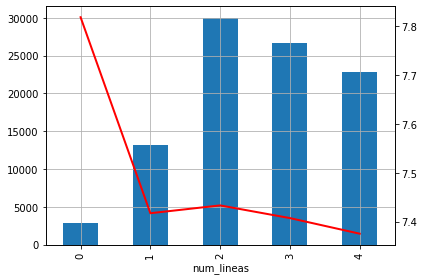

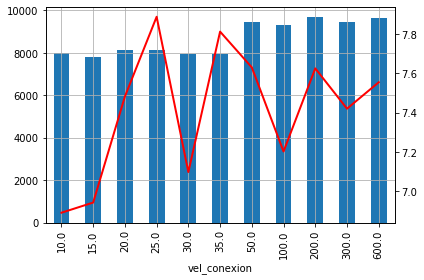

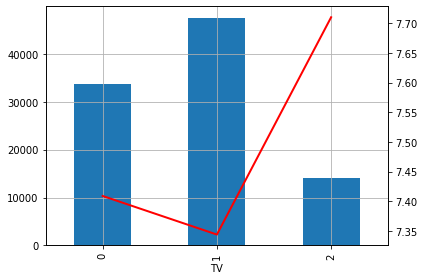

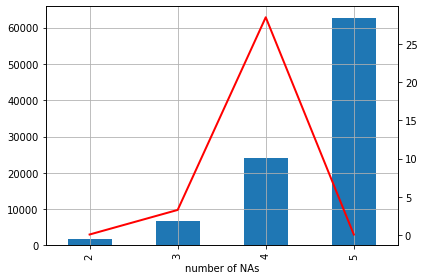

In [28]:
varsToPlot=data.loc[:,pd.DataFrame(data.columns, index=data.columns).apply(lambda x: len(data[x[0]].unique())<12 and len(data[x[0]].unique())>2, axis=1)]   
varsToPlot=varsToPlot.loc[:,list(pd.DataFrame(varsToPlot.columns).apply(lambda x: x[0] not in '¿Abandona?', axis=1))] 

for i in varsToPlot.columns:
    proporciones_final (i, '¿Abandona?', data) 

In [29]:
print(leyenda_LabelEncoder['values_num_lineas'])
print(leyenda_LabelEncoder['values_vel_conexion'])
print(leyenda_LabelEncoder['values_TV'])
print(leyenda_LabelEncoder['values_number of NAs']) 

   values  LabelEncoder equivalent
0       1                        0
1       2                        1
2       3                        2
3       4                        3
4       5                        4
   values  LabelEncoder equivalent
0   100MB                        0
1    10MB                        1
2    15MB                        2
3   200MB                        3
4    20MB                        4
5    25MB                        5
6   300MB                        6
7    30MB                        7
8    35MB                        8
9    50MB                        9
10  600MB                       10
        values  LabelEncoder equivalent
0  tv-familiar                        0
1    tv-futbol                        1
2     tv-total                        2
   values  LabelEncoder equivalent
0       0                        0
1       1                        1
2       2                        2
3       3                        3
4       4                        4


1. Observaciones:
    1. num_lineas: se ve claramente que cuando un cliente tiene cero líneas móviles contratadas, la probabilidad de dejar la empresa se dispara. Por tanto, creo una nueva variable llamada 'tiene_linea(s)_contratadas' que tiene valor 0 si el número de líneas contratadas son ceros y 1 para el resto.
    2. vel_conexion: sigue un comportamiento aleatorio. No creo nueva variable.
    3. TV: Si el paquete contratado es tipo '2', las probabilidades de abandonar se disparan. Creo una variable dummy ('con_paquete_TV_total') con valor 1 si es tipo '2' y 0 para el resto.
    4. number of NAs: También se observa que cuando el número de NAs en una fila es 4, dicho cliente tiene más probabilidades de abandonar. Por tanto, creo una nueva variable dummy ('con_4_NAs_en_fila') con valor 1 si el número de NAs es 4 y 0 para el resto


In [30]:
data['tiene_linea(s)_contratadas']=data.num_lineas.apply(lambda x: 0 if x==0 else 1) 
data['con_paquete_TV_total']=data.TV.apply(lambda x: 1 if x==2 else 0)
data['con_4_NAs_en_fila']=data['number of NAs'].apply(lambda x: 1 if x==4 else 0) 

### También se va a transformar las variables continuas:
#### Desventaja de discretizar variables continuas: pérdida de información
#### Posible ventaja: mejora la interpretabilidad
 El principal objetivo es encontrar patrones con respecto a la variable objetivo. 
 
 Selecciono un número relativamente grande de 'bins' con 'pandas.qcut()' (he selecciondad 20).  
 
 Por ejemplo, supongamos que los 10 primeros grupos (bins) de la variable x, tienen un ratio de gente que abandona muy inferior a los 10 grupos restantes. En tal caso, sería buena idea crear una variable binaria que explique este suceso.
 
 En el mismo ejemplo si en vez de q=20 hubiéramos elegido q=3 (es decir, se crean 3 bins), tendríamos la segunda  bin con valores de dos grupos muy diferentes: los que que tienen un ratio de gente que abandona muy bajo y los que, por el contrario, tienen un ratio mucho más alto. 
 
Esto supondría un problema porque al haber creado pocas bins, hemos perdido la capacidad de encontrar patrones (se vería un comportamiento progresivo ascendente con respecto a la variable objetivo, en lugar de una marcada diferencia). 
 
 Por este motivo, he usado 20 bins como medida de prevención.

###### IMPORTANTE DETALLE: la variable objetivo '¿Abandona?' tiene valores NAs para las observaciones de Enero. Precisamente por eso, el gráfico solo pinta la línea roja (de la variable objetivo) en función de los datos de Diciembre

In [31]:
def visualizar_variables_numericas_binarizadas(dataset, q, target='¿Abandona?'):
    sin_la_target=dataset.loc[:, dataset.columns != target]
    new_vars={}
    values=[i for i in range(q)]
    for i in range(len(sin_la_target.columns)):
        new_vars[str(sin_la_target.columns[i])]=pd.qcut(dataset[str(sin_la_target.columns[i])], 
                                                         q=q, labels=values)
    vars_to_plot=pd.DataFrame(new_vars).fillna(0) 
    target=pd.DataFrame(dataset[target])
    new_continuous_vars=pd.concat([target, vars_to_plot.reindex(target.index)], axis=1)  
    for i in vars_to_plot.columns:
        proporciones_final(i, '¿Abandona?', new_continuous_vars) 
        # Si en vez de "'¿Abandona?'" pongo "target" me da error

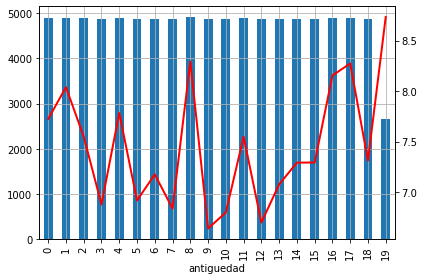

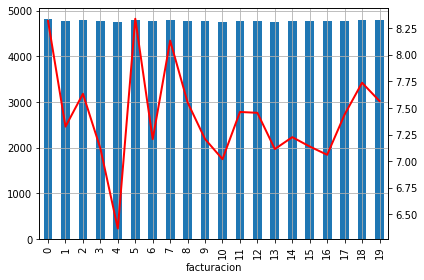

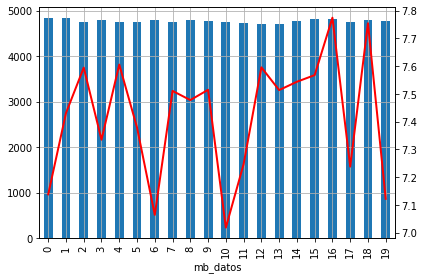

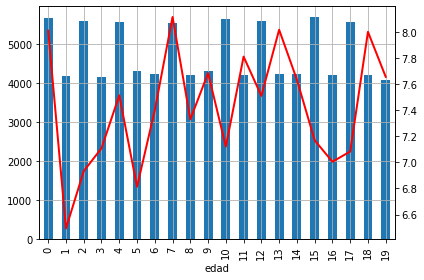

In [32]:
continuous_vars=data.loc[:,['antiguedad', 'facturacion', 'mb_datos', 'edad','¿Abandona?']] 
visualizar_variables_numericas_binarizadas(dataset=continuous_vars, q=20) 

Observaciones: Veo un comportamiento bastante aleatorio en las variables numéricas.
Solo voy a hacer una transformación con la variable 'edad' porque puede ayudar a ganar interpretabilidad.

Divido las edades por 'joven' (0-35), 'adulto' (35-60) y 'jubilado' (60-100)

Para evitar multicolineardiad, únicamente selecciono 'adulto' y 'jubilado'

In [33]:
edad_por_rangos=pd.cut(data.edad, bins=[0,35,60,100], labels=['joven','adulto',
                                                              'jubilado']) 
dummies_edad=pd.DataFrame(pd.get_dummies(edad_por_rangos).astype('int32'))
dummies_edad=dummies_edad.loc[:,['adulto','jubilado']]
data=pd.concat([data, dummies_edad.reindex(data.index)], axis=1)

# Evalúo la correlación de todas las variables y veo si las nuevas variables creadas están más correlacionadas que las antiguas

In [34]:
corr = abs(data.corr()) #since we have included a new var
corr[['¿Abandona?']].sort_values(by = '¿Abandona?',ascending = False).style.background_gradient() 

,¿Abandona?
¿Abandona?,1
con_4_NAs_en_fila,0.465407
number of NAs,0.223008
provincia,0.00630453
num_llamad_ent,0.00612962
con_paquete_TV_total,0.00459036
antiguedad,0.00314576
num_llamad_sal,0.00314091
edad,0.00286418
facturacion,0.00284625


### En general, la transformación de variables mejora considerablemente la correlación con la objetivo, aunque los valores siguen siendo muy bajos.
### La variable más significativa es 'con_4_NAs_en_fila', la cual ha conseguido duplicar la correlación de su variable original 'number of NAs'.

# Añadimos las variables que fueron eliminadas al principio del pre-procesado por tener muchos NAs. 


\
### Pero antes, evaluo si el dataset tiene algún NA.

In [35]:
data.isnull().sum() 

edad                              0
facturacion                       0
antiguedad                        0
provincia                         0
num_lineas                        0
num_llamad_ent                    0
num_llamad_sal                    0
mb_datos                          0
seg_llamad_ent                    0
seg_llamad_sal                    0
conexion                          0
vel_conexion                      0
TV                                0
Mes del dataset                   0
¿Abandona?                    92711
number of NAs                     0
tiene_linea(s)_contratadas        0
con_paquete_TV_total              0
con_4_NAs_en_fila                 0
adulto                            0
jubilado                          0
dtype: int64

### Voy a añadir las variables que quité al principio. 
### La razón por las que las eliminé fue debido a su gran número de NAs. Voy a convertir los NAs a cero con '.fillna(0)'. 
### Tomo esta decisión porque en varias variables como 'incidencia', 'financiacion' o 'descuentos' solo existe un único valor ('SI'). Por tanto, asumo que 'NA' se refiere a 'NO'.

In [36]:
full=pd.read_csv('full.csv')
others=full.loc[:,['num_dt','incidencia','financiacion','imp_financ','descuentos']]

for col in others.columns:
    print('column: {}'.format(str(col)))
    print(others[str(col)].unique()) 
    print() 

column: num_dt
[nan  2.  1.  4.  3.]

column: incidencia
[nan 'SI']

column: financiacion
[nan 'SI']

column: imp_financ
[        nan 31.55326856 28.51874706 ... 16.08319289 23.15835832
 21.29579583]

column: descuentos
[nan 'SI']



###### 'full' tiene las variables del dataset sin procesar. Por tanto, convierto la variable 'antiguedad' a formato fecha y creo nuevas variables, descomponiendo 'antiguedad' en 'dia', 'mes' y 'año'.

In [37]:
date_format=full.antiguedad.apply(lambda x: datetime.strptime(x, '%m/%d/%Y %I:%M %p'))
others['año_antiguedad']=pd.DatetimeIndex(date_format).year
others['mes_antiguedad']=pd.DatetimeIndex(date_format).month
others['dia_antiguedad']=pd.DatetimeIndex(date_format).day


for col in ['incidencia','financiacion','descuentos']:
    others[str(col)]=others[str(col)].map({'SI':1}) 
 
data=data.fillna(0) # for the last 5 NA values
fill_others=others.fillna(0) 
data=pd.concat([data, fill_others.reindex(data.index)], axis=1)

corr = abs(data.corr()) #since we have included a new var
corr[['¿Abandona?']].sort_values(by = '¿Abandona?',ascending = False).style.background_gradient() 

,¿Abandona?
¿Abandona?,1
num_dt,0.352727
con_4_NAs_en_fila,0.352215
incidencia,0.350084
number of NAs,0.161539
descuentos,0.0987662
financiacion,0.0521549
imp_financ,0.0472917
antiguedad,0.00553786
provincia,0.00456276


### Las variables añadidas son significativas.
### Visualizo el número de valores únicos de las nuevas variables. Si tiene un valor mayor que 2 utilizo la variable proporciones_final() para buscar transformaciones.

In [38]:
fill_others=fill_others.loc[:,fill_others.columns!='antiguedad']
fill_others.apply(lambda x: len(x.unique())) 

num_dt               5
incidencia           2
financiacion         2
imp_financ        6737
descuentos           2
año_antiguedad      26
mes_antiguedad      12
dia_antiguedad      31
dtype: int64

In [39]:
fill_others.isnull().sum() 

num_dt            0
incidencia        0
financiacion      0
imp_financ        0
descuentos        0
año_antiguedad    0
mes_antiguedad    0
dia_antiguedad    0
dtype: int64

### Visualizo 'num_dt', 'imp_financ', 'año_antiguedad', 'mes_antiguedad' y 'dia_antiguedad'

## proporciones_final() para 'num_dt'
### Creo la variable binaria 'tiene linea(s) en impago': si categoría es mayor que cero le asigno valor '1'

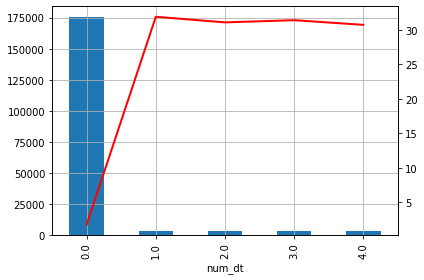

In [40]:
proporciones_final('num_dt', '¿Abandona?', data)

In [41]:
data['tiene linea(s) en impago']=data['num_dt'].apply(lambda x: 1 if x>0 else 0) 

In [42]:
data['tiene linea(s) en impago'].value_counts() 

0    175319
1     12859
Name: tiene linea(s) en impago, dtype: int64

## Estudio la variable 'imp_financ'

In [43]:
print(fill_others.imp_financ.describe())
fill_others.imp_financ.value_counts() 

count    188178.000000
mean          1.543039
std           6.256868
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          39.991954
Name: imp_financ, dtype: float64


0.000000     175140
5.828388          2
27.645342         2
30.768017         2
38.707231         2
              ...  
35.376380         1
20.289651         1
38.413568         1
29.944703         1
37.559554         1
Name: imp_financ, Length: 6737, dtype: int64

###### convierto la variable 'imp_financ' directamente a binaria porque la inmensa mayoría de sus valores son cero

In [44]:
data['paga importe por los terminales financiados']=data['imp_financ'].apply(lambda x: 0 if x==0 else 1) 
data['paga importe por los terminales financiados'].value_counts() 

0    175600
1     12578
Name: paga importe por los terminales financiados, dtype: int64

###### Visualizo las variables de año, mes y dia creando 11 'bins'.

Se puede inferir que la relación de las bins con la variable objetivo es bastante aleatoria.

Por tanto, no creo nuevas variables.

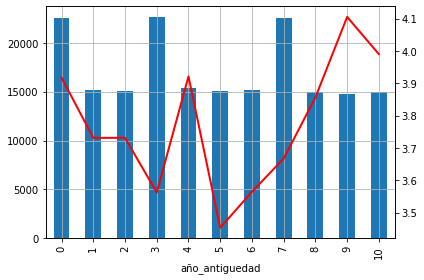

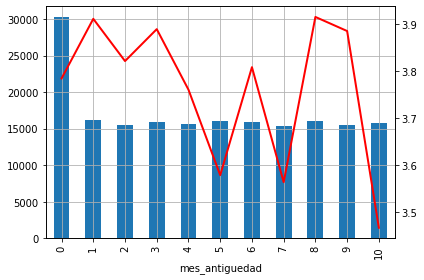

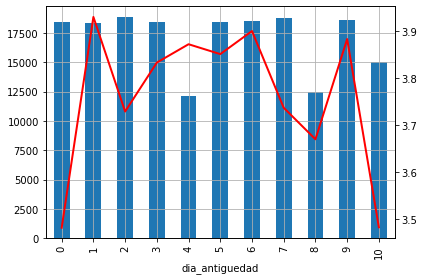

In [45]:
to_plot=fill_others.loc[:,['año_antiguedad', 'mes_antiguedad', 'dia_antiguedad']] 
target=data['¿Abandona?']
to_plot=pd.concat([target, to_plot.reindex(target.index)], axis=1)
to_plot
visualizar_variables_numericas_binarizadas(to_plot, 11)

In [46]:
corr = abs(data.corr()) 
corr[['¿Abandona?']].sort_values(by = '¿Abandona?',ascending = False).style.background_gradient() 

,¿Abandona?
¿Abandona?,1
tiene linea(s) en impago,0.391333
num_dt,0.352727
con_4_NAs_en_fila,0.352215
incidencia,0.350084
number of NAs,0.161539
descuentos,0.0987662
paga importe por los terminales financiados,0.0521549
financiacion,0.0521549
imp_financ,0.0472917


#### La parte de feature engineering queda acabada.
#### Ahora comienzo la selección de variables.
Pero antes, reviso que no hay valores NAs

In [47]:
data.isnull().sum() 

edad                                           0
facturacion                                    0
antiguedad                                     0
provincia                                      0
num_lineas                                     0
num_llamad_ent                                 0
num_llamad_sal                                 0
mb_datos                                       0
seg_llamad_ent                                 0
seg_llamad_sal                                 0
conexion                                       0
vel_conexion                                   0
TV                                             0
Mes del dataset                                0
¿Abandona?                                     0
number of NAs                                  0
tiene_linea(s)_contratadas                     0
con_paquete_TV_total                           0
con_4_NAs_en_fila                              0
adulto                                         0
jubilado            

# Uso el método VIF para detectar multicolinearidad

In [49]:
from sklearn.linear_model import LinearRegression

def calculateVIF(data):
    features = list(data.columns)
    num_features = len(features)
    
    model = LinearRegression()
    
    result = pd.DataFrame(index = ['VIF'], columns = features)
    result = result.fillna(0)
    
    for ite in range(num_features):
        x_features = features[:]
        y_featue = features[ite]
        x_features.remove(y_featue)
        
        x = data[x_features]
        y = data[y_featue]
        
        model.fit(data[x_features], data[y_featue])
        
        result[y_featue] = 1/(1 - model.score(data[x_features], data[y_featue]))
    
    return result


def selectDataUsingVIF(data, max_VIF = 5):
    result = data.copy(deep = True)
    
    VIF = calculateVIF(result)
    
    while VIF.as_matrix().max() > max_VIF:
        col_max = np.where(VIF == VIF.as_matrix().max())[1][0]
        features = list(result.columns)
        features.remove(features[col_max])
        result = result[features]
        
        VIF = calculateVIF(result)
        
    return result



colli=list(selectDataUsingVIF(data.loc[:,list(pd.DataFrame(data.columns).apply(lambda x: x[0] not in ['¿Abandona?','Mes del dataset'], axis=1))]).columns) 
colli.extend(['Mes del dataset','¿Abandona?'])

C:\Users\pablo\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\pablo\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\pablo\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\pablo\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\pablo\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\pablo\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\pablo\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: Method .as_matri

#### Examino que variables fueron eliminadas por VIF

In [50]:
columns=pd.DataFrame({'col1':data.columns}) 
mask=list(data.columns[columns.isin(colli).col1]) 

vars_removed_by_VIF=list(data.columns[columns.apply(lambda x: x[0] not in mask, axis=1)]) 
vars_removed_by_VIF

['jubilado',
 'financiacion',
 'tiene linea(s) en impago',
 'paga importe por los terminales financiados']

In [51]:
corr = abs(data.corr()) 
corr.loc[:,vars_removed_by_VIF][data.corr()>0.7]

,jubilado,financiacion,tiene linea(s) en impago,paga importe por los terminales financiados
edad,0.834356,NaN,NaN,NaN
facturacion,NaN,NaN,NaN,NaN
antiguedad,NaN,NaN,NaN,NaN
provincia,NaN,NaN,NaN,NaN
num_lineas,NaN,NaN,NaN,NaN
num_llamad_ent,NaN,NaN,NaN,NaN
num_llamad_sal,NaN,NaN,NaN,NaN
mb_datos,NaN,NaN,NaN,NaN
seg_llamad_ent,NaN,NaN,NaN,NaN
seg_llamad_sal,NaN,NaN,NaN,NaN


###### Como se puede observar, las siguientes variables están altamente correlacionadas entre ellas:
    1. jubilado <-> edad
    2. financiacion <-> imp_financ, paga importe por los terminales financiados
    3. tiene linea(s) en impago <-> num_dt
    4. paga importe por los terminales financiados <-> financiacion, imp_financ

## Me quedo con las que están más correlacionadas con la variable objetivo

In [52]:
corr = abs(data.corr()) 
corr[['¿Abandona?']].sort_values(by = '¿Abandona?',ascending = False).style.background_gradient() 

,¿Abandona?
¿Abandona?,1
tiene linea(s) en impago,0.391333
num_dt,0.352727
con_4_NAs_en_fila,0.352215
incidencia,0.350084
number of NAs,0.161539
descuentos,0.0987662
paga importe por los terminales financiados,0.0521549
financiacion,0.0521549
imp_financ,0.0472917


### Selecciono ('edad', 'tiene linea(s) en impago', 'paga importe por los terminales financiados') y elimino ('jubilado', 'financiacion', 'imp_financ', 'num_dt') 

In [53]:
data=data.loc[:,
             list(pd.DataFrame(data.columns).apply(lambda x: x[0] not in ['jubilado',
                                                                          'financiacion',
                                                                          'imp_financ',
                                                                          'num_dt'], 
                                                   axis=1))]


#### Compruebo que no hay mas problemas de colinearidad
Como se puede comprobar, len(colli)==len(data.columns). Por tanto, ninguna variable ha sido eliminada

In [54]:
colli=list(selectDataUsingVIF(data.loc[:,list(pd.DataFrame(data.columns).apply(lambda x: x[0] not in ['¿Abandona?','Mes del dataset'], axis=1))]).columns) 
colli.extend(['Mes del dataset','¿Abandona?']) 
len(colli)==len(data.columns)

C:\Users\pablo\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


True

#### Selección de variables.
###### Uso los siguientes métodos:
    1. VarianceThreshold(threshold = 0.60)
    2. SelectKBest(chi2, k=20)
    3. SelectFromModel(estimator=LinearSVC(C=0.01, penalty="l1", dual=False))
    4. SelectFromModel(estimator=ExtraTreesClassifier(n_estimators=50))

In [55]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import LinearSVC
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier

data=data.rename(columns={'Mes del dataset':'Mes_del_dataset', 
              'tiene linea(s) en impago':'tiene_linea(s)_en_impago', 
              'paga importe por los terminales financiados':'paga_importe_por_los_terminales_financiados'})



y=data.loc[data['Mes_del_dataset']=='Diciembre', '¿Abandona?']

X=data.loc[data['Mes_del_dataset']=='Diciembre',
            list(pd.DataFrame(data.columns).apply(lambda x: x[0] not in ['¿Abandona?',
                                                                           'Unnamed: 0',
                                                                           'Mes_del_dataset'], 
                                                   axis=1))] 

var_th = VarianceThreshold(threshold = 0.60)
x_var = var_th.fit_transform(X) 
variance_selection=pd.DataFrame({'variance_selection':np.asarray(list(X))[var_th.get_support()]})

var_th = SelectKBest(chi2, k=20)
x_var  = var_th.fit_transform(X, y) # it is a model
chi2_selection=pd.DataFrame({'chi2_selection':np.asarray(list(X))[var_th.get_support()]})

selector=SelectFromModel(estimator=LinearSVC(C=0.01, penalty="l1", dual=False)).fit(X, y) 
lsvc_selection=pd.DataFrame({'lsvc_selection':X.columns[selector.get_support()]}) 

selector=SelectFromModel(estimator=ExtraTreesClassifier(n_estimators=50)).fit(X, y) 
tree_selection=pd.DataFrame({'tree_selection':X.columns[selector.get_support()]}) 

  
corr_with_target=pd.DataFrame({'corr_with_target':abs(data.corr()).loc[:,'¿Abandona?']}).sort_values(by='corr_with_target',ascending=False) 
corr_with_target=pd.DataFrame({'corr_with_target':list(corr_with_target.index[1:])})

table=pd.concat([variance_selection, chi2_selection, lsvc_selection, tree_selection, 
           corr_with_target], axis=1, sort=False) 
table

C:\Users\pablo\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,variance_selection,chi2_selection,lsvc_selection,tree_selection,corr_with_target
0,edad,edad,edad,number of NAs,tiene_linea(s)_en_impago
1,facturacion,facturacion,facturacion,con_4_NAs_en_fila,con_4_NAs_en_fila
2,antiguedad,antiguedad,provincia,incidencia,incidencia
3,provincia,provincia,num_lineas,descuentos,number of NAs
4,num_lineas,num_llamad_ent,num_llamad_sal,tiene_linea(s)_en_impago,descuentos
5,num_llamad_ent,num_llamad_sal,number of NAs,NaN,paga_importe_por_los_terminales_financiados
6,num_llamad_sal,mb_datos,con_4_NAs_en_fila,NaN,antiguedad
7,mb_datos,seg_llamad_ent,incidencia,NaN,provincia
8,seg_llamad_ent,seg_llamad_sal,descuentos,NaN,num_llamad_ent
9,seg_llamad_sal,vel_conexion,año_antiguedad,NaN,con_paquete_TV_total


#### Como se puede observar hay disparidad en las variables seleccionadas por los distintos métodos:
    1. Mientras 'VarianceThreshold', 'chi2' y 'LinearSupportVectorClassifier' proponen variables parecidas, 'ExtraTreesClassifier' propone variables completamente diferentes.
    2. Es interesante recalcar que las variables de 'ExtraTreesClassifier' son mucho más afines al nivel de correlación que tienen estas variables con la target.
    3. Sin embargo, en los otros métodos (edad, facturacion, provincia) son variables consideradas muy importantes, a pesar de tener una correlación de (0.0021, 0.0020, 0.0045), respectivamente. Por tanto, esto no es buen síntoma.

### Estrategia que voy a seguir:
Voy a crear 4 dataset incluyendo las variables en 'variance_selection', 'chi2_selection', 'lsvc_selection' y 'tree_selection'; respectivamente.

Voy a tirar regresión logística y random forest a cada uno de estos modelos.

Si los resultados son bastantes parecidos, elijo entonces 'tree_selection' porque es la que menos variables tiene.

In [56]:
chi2=list(table.chi2_selection[:20]) 
chi2.extend(['Mes_del_dataset','¿Abandona?']) 

variance=list(table.variance_selection[:14])
variance.extend(['Mes_del_dataset','¿Abandona?'])

lsvc=list(table.lsvc_selection[:13])
lsvc.extend(['Mes_del_dataset','¿Abandona?'])

trees=list(table.tree_selection[:5])
trees.extend(['Mes_del_dataset','¿Abandona?'])

variance=data.loc[:,variance] 
chi2=data.loc[:,chi2] 
lsvc=data.loc[:,lsvc]
trees=data.loc[:,trees]

In [57]:
def check_vars_selected(dataset, classifier='logistic_regression'):
    
    dataset=dataset
    data_diciembre=dataset.loc[dataset['Mes_del_dataset']=='Diciembre',list(pd.DataFrame(dataset.columns).apply(lambda x: x[0] not in ['Mes_del_dataset'], axis=1))] 
    restOfVars=data_diciembre.loc[:, list(pd.DataFrame(data_diciembre.columns).apply(lambda x: x[0] not in ['TV_tv-total', 'num_lineas_5','¿Abandona?'], axis=1))]  
    target=data_diciembre['¿Abandona?']
    data_diciembre=pd.concat([restOfVars, target.reindex(target.index)], axis=1) 

    X, y = data_diciembre.iloc[:,:-1], data_diciembre.iloc[:,-1] 
    scaler = MinMaxScaler()    
    X=scaler.fit_transform(X) 

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)
    if classifier != 'logistic_regression':
        classifier = RandomForestClassifier(n_estimators=100, random_state=0).fit(X_train, y_train)
    else:
        classifier = LogisticRegression().fit(X_train, y_train)
    y_pred     = classifier.predict(X_test) 

    print(saca_metricas(y_test, y_pred))  
    print('\nAhora con el dataset de Enero')
    data_enero=dataset.loc[dataset['Mes_del_dataset']=='Enero',list(pd.DataFrame(dataset.columns).apply(lambda x: x[0] not in ['Mes_del_dataset'], axis=1))] 
    X_test_enero=data_enero.loc[:,list(pd.DataFrame(data_enero.columns).apply(lambda x: x[0] not in ['¿Abandona?'], axis=1))]
    scaler = MinMaxScaler()    
    X_test_enero=scaler.fit_transform(X_test_enero) 
    
    y_pred_Enero=classifier.predict(X_test_enero)

    print('number of ones: {}'.format(len(y_pred_Enero[y_pred_Enero==1]))) 
    print('number of zeros: {}'.format(len(y_pred_Enero[y_pred_Enero==0]))) 
    print('ratio of ones: {}%'.format(round((len(y_pred_Enero[y_pred_Enero==1])/len(y_pred_Enero))*100,3)))    
    print()

    y_pred_proba_Enero=classifier.predict_proba(X_test_enero)

    probs=pd.DataFrame(y_pred_proba_Enero, index=data_enero.index) 
    probs.columns=['prob de NO abandonar ("¿Abandona?"=0)', 'prob de abandonar ("¿Abandona?"=1)'] 


 REGRESION LOGISTICA


 METHOD: variance
matriz de confusión
[[22096     0]
 [ 1771     0]]
accuracy
0.9257971257384673
precision
0.0
recall
0.0
f1
0.0
AUC
0.5
None

Ahora con el dataset de Enero
number of ones: 0

C:\Users\pablo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



number of zeros: 92711
ratio of ones: 0.0%

None







 METHOD: chi2
matriz de confusión
[[21680   416]
 [   12  1759]]
accuracy
0.9820672895629949
precision
0.8087356321839081
recall
0.9932241671372106
f1
0.8915357323872276
AUC
0.9871986150675192
None

Ahora con el dataset de Enero
number of ones: 1878
number of zeros: 90833
ratio of ones: 2.026%

None







 METHOD: lsvc
matriz de confusión
[[21677   419]
 [   12  1759]]
accuracy
0.9819415929945112
precision
0.8076216712580349
recall
0.9932241671372106
f1
0.8908584451759939
AUC
0.987130729477367
None

Ahora con el dataset de Enero
number of ones: 1977
number of zeros: 90734
ratio of ones: 2.132%

None







 METHOD: trees
matriz de confusión
[[21677   419]
 [   12  1759]]
accuracy
0.9819415929945112
precision
0.8076216712580349
recall
0.9932241671372106
f1
0.8908584451759939
AUC
0.987130729477367
None

Ahora con el dataset de Enero
number of ones: 1977
number of zeros: 90734
ratio of ones: 2.132%

None







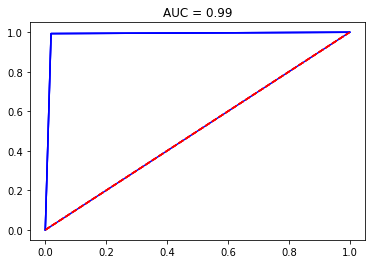

In [58]:
dict_methods={}
dict_methods['variance']=variance
dict_methods['chi2']=chi2
dict_methods['lsvc']=lsvc
dict_methods['trees']=trees

print('\n REGRESION LOGISTICA')
for method in dict_methods:
    print('\n\n METHOD: {}'.format(method)) 
    print(check_vars_selected(dict_methods[method])) 
    print('\n\n\n\n')


 RANDOM FOREST


 METHOD: variance
matriz de confusión
[[22096     0]
 [ 1771     0]]
accuracy
0.9257971257384673
precision
0.0
recall
0.0
f1
0.0
AUC
0.5
None

Ahora con el dataset de Enero


C:\Users\pablo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


number of ones: 0
number of zeros: 92711
ratio of ones: 0.0%

None







 METHOD: chi2
matriz de confusión
[[21680   416]
 [   13  1758]]
accuracy
0.9820253907068337
precision
0.8086476540938362
recall
0.9926595143986449
f1
0.8912547528517111
AUC
0.9869162886982362
None

Ahora con el dataset de Enero
number of ones: 2024
number of zeros: 90687
ratio of ones: 2.183%

None







 METHOD: lsvc
matriz de confusión
[[21680   416]
 [   15  1756]]
accuracy
0.9819415929945112
precision
0.8084714548802947
recall
0.9915302089215132
f1
0.8906923662186153
AUC
0.9863516359596705
None

Ahora con el dataset de Enero
number of ones: 2024
number of zeros: 90687
ratio of ones: 2.183%

None







 METHOD: trees
matriz de confusión
[[21680   416]
 [   12  1759]]
accuracy
0.9820672895629949
precision
0.8087356321839081
recall
0.9932241671372106
f1
0.8915357323872276
AUC
0.9871986150675192
None

Ahora con el dataset de Enero
number of ones: 1972
number of zeros: 90739
ratio of ones: 2.127%

None







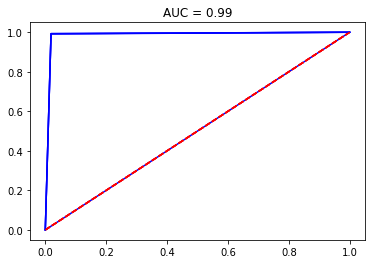

In [59]:
print('\n RANDOM FOREST')
for method in dict_methods:
    print('\n\n METHOD: {}'.format(method)) 
    print(check_vars_selected(dict_methods[method], classifier='randomForest')) 
    print('\n\n\n\n') 

###### Observaciones:
    1. En regresión logística, si se observa la matriz confusión, empatan 'chi2' y 'lsvc' con 12 falsos negativos y 416 falsos positivos. Mientras que 'trees' queda con 12 falsos negativos y 419 falsos positivos.
    2. En Random Forest, hay un claro vencedor 'trees' con 12 FN y 416 FP. Aunque le siguen muy de cerca 'chi2' y 'lsvc' con mismo FPs y 13, 15 FNs, respectivamente.

### Cualquiera de los 3 modelos es bueno.
Sin embargo, dado que es una prioridad usar el menor de número de variables para ganar interpretabilidad, elijo las variables propuesta por 'trees'

In [60]:
data_trees=trees
data_trees.head(2) 

,number of NAs,con_4_NAs_en_fila,incidencia,descuentos,tiene_linea(s)_en_impago,Mes_del_dataset,¿Abandona?
0,5,0,0.0,0.0,0,Diciembre,0.0
1,4,1,0.0,1.0,0,Diciembre,0.0


# Interpretación de las variables:
###### Obtener y explicar las claves (a través de las variables…) de la marcha de los clientes en la compañía:

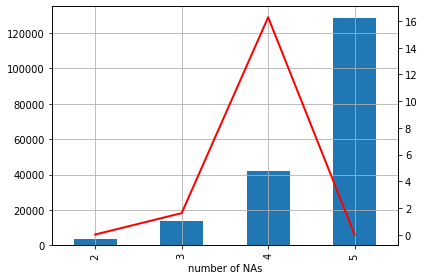

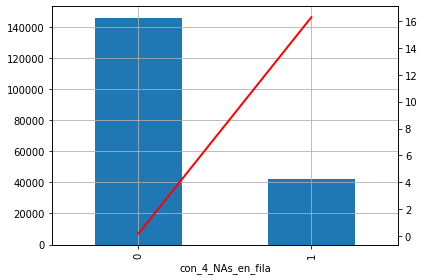

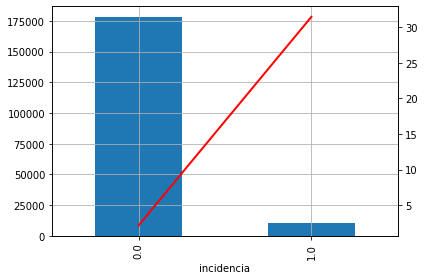

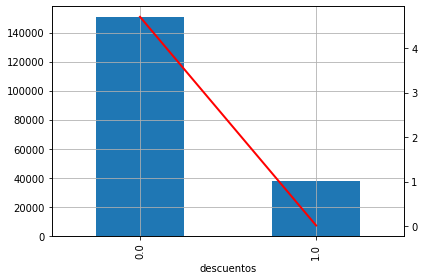

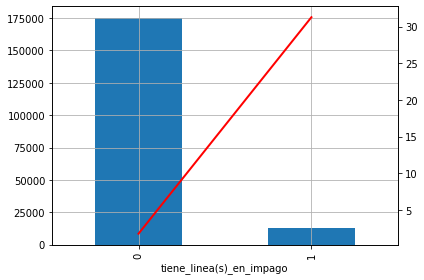

In [61]:
names=data_trees.columns[list(pd.DataFrame(data_trees.columns).apply(lambda x: x[0] not in ['Mes_del_dataset','¿Abandona?'], axis=1))]                                   
for i in names:
    proporciones_final(i, '¿Abandona?', data)

#### Candidatos a dejar la empresa:
    1. Clientes con líneas en impago (variable: 'tiene_linea(s)_en_impago').
    2. Clientes con incidencias/reclamaciones (variable: incidencia).
    5. Clientes que no tienen ningún tipo de descuento (variable: descuentos).
    6. Clientes que en su fila de variables tiene 4 NAs (Que es una combinación (suma) de las anteriores). (variables: 'con_4_NAs_en_fila' y 'number_of_NAs')

### Antes de lanzar modelos, voy a comprobar que no hay NAs
##### Añado 'Mes del dataset' que luego usaré para hacer la partición Enero/Febrero al lanzar modelos

In [62]:
data_trees.isnull().sum() 

number of NAs               0
con_4_NAs_en_fila           0
incidencia                  0
descuentos                  0
tiene_linea(s)_en_impago    0
Mes_del_dataset             0
¿Abandona?                  0
dtype: int64

#### Añado el Id del cliente como índice del data frame

In [63]:
id_values=pd.read_csv('full.csv')['id'] 
data_trees.index=id_values
data_trees.head(2) 

,number of NAs,con_4_NAs_en_fila,incidencia,descuentos,tiene_linea(s)_en_impago,Mes_del_dataset,¿Abandona?
id,,,,,,,
1,5,0,0.0,0.0,0,Diciembre,0.0
2,4,1,0.0,1.0,0,Diciembre,0.0


# Tiro modelos
###### Uso random forest porque es el modelo que me dio mejor resultado para data_trees

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve

In [65]:
def evaluacion_modelo(dataset, model):
    
    dataset=dataset
    data_diciembre=dataset.loc[dataset['Mes_del_dataset']=='Diciembre',list(pd.DataFrame(dataset.columns).apply(lambda x: x[0] not in ['Mes_del_dataset'], axis=1))] 
    restOfVars=data_diciembre.loc[:, list(pd.DataFrame(data_diciembre.columns).apply(lambda x: x[0] not in ['TV_tv-total', 'num_lineas_5','¿Abandona?'], axis=1))]  
    target=data_diciembre['¿Abandona?']
    data_diciembre=pd.concat([restOfVars, target.reindex(target.index)], axis=1) 

    X, y = data_diciembre.iloc[:,:-1], data_diciembre.iloc[:,-1] 
    scaler = MinMaxScaler()    
    X=scaler.fit_transform(X) 

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)
    classifier = model.fit(X_train, y_train)
    y_pred     = classifier.predict(X_test) 

    print(saca_metricas(y_test, y_pred)) 
    
    print('\nAhora con el dataset de Enero')
    data_enero=dataset.loc[dataset['Mes_del_dataset']=='Enero',list(pd.DataFrame(dataset.columns).apply(lambda x: x[0] not in ['Mes_del_dataset'], axis=1))] 
    X_test_enero=data_enero.loc[:,list(pd.DataFrame(data_enero.columns).apply(lambda x: x[0] not in ['¿Abandona?'], axis=1))]
    scaler = MinMaxScaler()    
    X_test_enero=scaler.fit_transform(X_test_enero) 

    print('================================================================')
    print('Predicción de los clientes que se van a marchar en Febrero: \nsi es "1" cliente abadona, "0" si continúa')
    print('================================================================') 
    print()
    print('X_test_enero shape: {}'.format(X_test_enero.shape))
    print() 
    y_pred_Enero=classifier.predict(X_test_enero)

    print('number of ones: {}'.format(len(y_pred_Enero[y_pred_Enero==1]))) 
    print('number of zeros: {}'.format(len(y_pred_Enero[y_pred_Enero==0]))) 
    print('ratio of ones: {}%'.format(round((len(y_pred_Enero[y_pred_Enero==1])/len(y_pred_Enero))*100,3)))    
    print()
#     print(pd.DataFrame(y_pred_Enero, index=data_enero.index) )

    y_pred_proba_Enero=classifier.predict_proba(X_test_enero)
    print()
    print('probabilities')
    probs=pd.DataFrame(y_pred_proba_Enero, index=data_enero.index) 
    probs.columns=['prob de NO abandonar ("¿Abandona?"=0)', 'prob de abandonar ("¿Abandona?"=1)']
    print(pd.DataFrame(probs)) 

matriz de confusión
[[21680   416]
 [   12  1759]]
accuracy
0.9820672895629949
precision
0.8087356321839081
recall
0.9932241671372106
f1
0.8915357323872276
AUC
0.9871986150675192
None

Ahora con el dataset de Enero
Predicción de los clientes que se van a marchar en Febrero: 
si es "1" cliente abadona, "0" si continúa

X_test_enero shape: (92711, 5)

number of ones: 1972
number of zeros: 90739
ratio of ones: 2.127%


probabilities
        prob de NO abandonar ("¿Abandona?"=0)  \
id                                              
1                                    0.999559   
2                                    0.999837   
3                                    0.999837   
4                                    0.999559   
6                                    0.713905   
...                                       ...   
99996                                0.999523   
99997                                0.998519   
99998                                0.999559   
99999                      

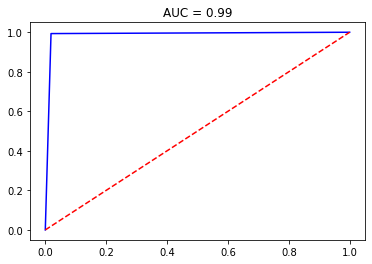

In [66]:
model=RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
evaluacion_modelo(data_trees, model)

### Idenfico la mejor combinación de parámetros con GridSearchCV

In [71]:
# Defino un modelo de random forest:
rand_forest_model = RandomForestClassifier(random_state=0, n_jobs=-1, verbose=1)
# n_jobs=-1 para hacer computación en paralelo

grid_param = {
    "n_estimators": [100, 300, 500],
    'criterion': ['gini', 'entropy'],
    "max_depth": [5,8,15],
    'bootstrap': [True, False],
    "min_samples_leaf" : [1, 2, 4]
}

# Aplicar el grid sobre el modelo:
model_grid = GridSearchCV(estimator=rand_forest_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [72]:
dataset=data_trees
data_diciembre=dataset.loc[dataset['Mes_del_dataset']=='Diciembre',list(pd.DataFrame(dataset.columns).apply(lambda x: x[0] not in ['Mes_del_dataset'], axis=1))] 
restOfVars=data_diciembre.loc[:, list(pd.DataFrame(data_diciembre.columns).apply(lambda x: x[0] not in ['TV_tv-total', 'num_lineas_5','¿Abandona?'], axis=1))]  
target=data_diciembre['¿Abandona?']
data_diciembre=pd.concat([restOfVars, target.reindex(target.index)], axis=1) 

X, y = data_diciembre.iloc[:,:-1], data_diciembre.iloc[:,-1] 
scaler = MinMaxScaler()    
X=scaler.fit_transform(X) 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)
classifier = model_grid.fit(X_train, y_train)

###### Observo los resultados del mejor modelo (el accuracy se mide con el train set, por eso los resultados son un poco más altos que con el test set)

In [75]:
print(classifier.best_score_)
print(classifier.best_params_)
print(classifier.best_estimator_) 

0.9843016759776537
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 100}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


matriz de confusión
[[21680   416]
 [   12  1759]]
accuracy
0.9820672895629949
precision
0.8087356321839081
recall
0.9932241671372106
f1
0.8915357323872276
AUC
0.9871986150675192
None

Ahora con el dataset de Enero
Predicción de los clientes que se van a marchar en Febrero: 
si es "1" cliente abadona, "0" si continúa

X_test_enero shape: (92711, 5)

number of ones: 2192
number of zeros: 90519
ratio of ones: 2.364%


probabilities
        prob de NO abandonar ("¿Abandona?"=0)  \
id                                              
1                                    0.999559   
2                                    0.999837   
3                                    0.999837   
4                                    0.999559   
6                                    0.755650   
...                                       ...   
99996                                0.999480   
99997                                0.998519   
99998                                0.999559   
99999                      

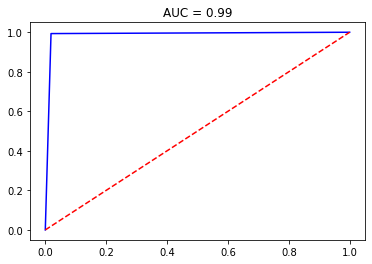

In [84]:
my_best_model=classifier.best_estimator_
evaluacion_modelo(data_trees, my_best_model)

# Red Neuronal desde cero con python (opcional)

Vectorizo y traspongo los datos para luego poder hacer la multiplicación vectorial de la activación_cero (mi fila de datos), con los pesos de la siguiente capa (la capa 1).

In [67]:
dataset=data_trees
data_diciembre=dataset.loc[dataset['Mes_del_dataset']=='Diciembre',list(pd.DataFrame(dataset.columns).apply(lambda x: x[0] not in ['Mes_del_dataset'], axis=1))] 
X, y = data_diciembre.iloc[:,data_diciembre.columns!='¿Abandona?'], data_diciembre.iloc[:,data_diciembre.columns=='¿Abandona?']

scaler = MinMaxScaler()    
X=scaler.fit_transform(X) 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)
X_train, X_test, y_train, y_test = (np.array(X_train).T, np.array(X_test).T, 
                                    np.array(y_train).reshape(1,-1), 
                                    np.array(y_test).reshape(1,-1)) 

1. Varias funciones:
    1. La inicialización de los pesos depende del numero de capas que queramos crear. El argumento 'layer_dims' hay que pasarlo como lista y el primer elemento tiene que ser igual al número de 'input features' (las variables).
    2. Hacemos la computación matricial de las distintas capas, guardando los resultados en diccionarios y calculamos el coste. Este coste es una función logarítmica de la probabilidad que nos da la sigmoide en la última capa (y_pred) y el valor real de la target en esa observación. Uso una función logarítmica en la función de costes porque ayuda a la propagación_hacia_atrás encontrar el mínimo.
    3. Hacemos la propagación_hacia_atrás usando la regla de cadena. Es importante mencionar que hemos usado la sigmoide como función activación de la última capa y ReLU para el resto. Una gran ventaja de usar la ReLU es que simplifica mucho la derivación.

In [68]:
def initialization(layer_dims): #layer_dims has to be a list
    np.random.seed(1)  # to reproduce values
    parameters={}
    for l in range(1,len(layer_dims)):
        parameters['W'+str(l)]=np.random.randn(layer_dims[l],layer_dims[l-1])*0.01 
        parameters['b'+str(l)]=np.zeros((layer_dims[l],1))
    return parameters


# sigmoid as activation function in last layer, ReLU for remaining ones
def forward_propagation_AND_cost_computation(X, Y, parameters):
    forward_param={}
    A_prev=X
    layers=int(len(parameters)/2) 
    for l in range(1,layers): 
        forward_param['Z'+str(l)]=np.dot(parameters['W'+str(l)], A_prev)+parameters['b'+str(l)] 
        forward_param['A'+str(l)]=np.maximum(0, forward_param['Z'+str(l)]) #ReLU activation function
        A_prev=forward_param['A'+str(l)]

    #Last layer
    forward_param['Z'+str(layers)]=np.dot(parameters['W'+str(layers)], 
                                          A_prev)+parameters['b'+str(layers)]    
    forward_param['A'+str(layers)]=1/(1+np.exp(-(forward_param['Z'+str(layers)])))  

    Y=Y.reshape(1,-1) 
    
    AL=forward_param['A'+str(int(len(parameters)/2))].reshape(1,-1)
    #str(len(forward_param)/2)[0] returns '2.0'[0], which is only '2'
    m=Y.shape[1] 

    cost=-(1/m)*np.sum(Y*np.log(AL)+(1-Y)*np.log(1-AL))   
    
    return cost, forward_param, parameters



def backward_propagation(X, Y, parameters):
    loss, forward_param, weights = forward_propagation_AND_cost_computation(X, Y, parameters) #'forward_param' -> 'As' and 'Zs'
    grads={}
    last_layer = int(len(forward_param)/2) 
    m=Y.shape[1] 
    forward_param['A0']=X
    
    grads['dZ'+str(last_layer)]=forward_param['A'+str(last_layer)] - Y #here activation: sigmoid.
                                                                       #following layers: ReLU
    previous_dZ=grads['dZ'+str(last_layer)]
    for l in reversed(range(1,last_layer+1)):
        grads['dW'+str(l)] = ((1/m) * np.dot(previous_dZ, 
                                               forward_param['A'+str(l-1)].T))   
        grads['db'+str(l)] = (1/m) * np.sum(previous_dZ, axis=1, keepdims=True)
        
        if l>1:
            grads['dZ'+str(l-1)] = (np.dot(weights['W'+str(l)].T, previous_dZ) * 
                                    np.array(forward_param['Z'+str(l-1)]>=0, dtype=float))    
            
            previous_dZ = grads['dZ'+str(l-1)]
            
    return grads

Actualizamos los parámetros de la forma clásica.

In [69]:
# standard update of parameters
def gradient_update(parameters, grads, learning_rate=1):
    for l in range(1, int(len(parameters)/2+1)):    
        parameters['W'+str(l)] = parameters['W'+str(l)] - learning_rate * grads['dW'+str(l)]
        parameters['b'+str(l)] = parameters['b'+str(l)] - learning_rate * grads['db'+str(l)] 
    return parameters

Problema de actualizar los parámetros de la forma clásica: 

1. Sería interesante que el 'learning_rate' estuviera influenciado por 'learning_rates' de previas iteraciones. De esta manera, se podría conseguir un efecto suavizador en el aprendizaje.


2. Además, sería buena idea incluir unos parámetros que, a su vez penalizaran parámetros de la matriz de pesos (de las distintas capas), cuando estos tengan valores muy altos. De esta manera, también conseguir un efecto suavizador en el aprendizaje.

La actualización de parámetros tipo Adam resuleve este problema:

Esta es la fórmula general, para $l = 1, ..., L$: 

$$\begin{cases}
v_{W^{[l]}} = \beta_1 v_{W^{[l]}} + (1 - \beta_1) \frac{\partial J }{ \partial W^{[l]} } \\
v^{corrected}_{W^{[l]}} = \frac{v_{W^{[l]}}}{1 - (\beta_1)^t} \\
s_{W^{[l]}} = \beta_2 s_{W^{[l]}} + (1 - \beta_2) (\frac{\partial J }{\partial W^{[l]} })^2 \\
s^{corrected}_{W^{[l]}} = \frac{s_{W^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{W^{[l]}}}{\sqrt{s^{corrected}_{W^{[l]}}}+\varepsilon}
\end{cases}$$ 

In [70]:
def initialize_adam(parameters) :
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}

    for l in range(L):
        v["dW" + str(l+1)] = np.zeros(parameters['W'+str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters['b'+str(l+1)].shape)
        s["dW" + str(l+1)] = np.zeros(parameters['W'+str(l+1)].shape)
        s["db" + str(l+1)] = np.zeros(parameters['b'+str(l+1)].shape)
    return v, s




def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(L):
        v["dW" + str(l+1)] = beta1*v['dW'+str(l+1)] + (1-beta1)*grads['dW'+str(l+1)]
        v["db" + str(l+1)] = beta1*v['db'+str(l+1)] + (1-beta1)*grads['db'+str(l+1)]

        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)]/(1-beta1**t)
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)]/(1-beta1**t)

        s["dW" + str(l+1)] = beta2*s['dW'+str(l+1)] + (1-beta2)*(grads['dW'+str(l+1)]**2)
        s["db" + str(l+1)] = beta2*s['db'+str(l+1)] + (1-beta2)*(grads['db'+str(l+1)]**2)

        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)]/(1-beta2**t)
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)]/(1-beta2**t)

        parameters["W" + str(l+1)] = parameters['W'+str(l+1)] - (learning_rate*(v_corrected['dW'+str(l+1)]/(np.sqrt(s_corrected['dW'+str(l+1)])+epsilon)))  
        parameters["b" + str(l+1)] = parameters['b'+str(l+1)] - (learning_rate*(v_corrected['db'+str(l+1)]/(np.sqrt(s_corrected['db'+str(l+1)])+epsilon)))

    return parameters

Función para sacar la y_pred

In [71]:
def predict(X, parameters):
    forward_param={}
    A_prev=X
    layers=int(len(parameters)/2) 
    for l in range(1,layers): 
        forward_param['Z'+str(l)]=np.dot(parameters['W'+str(l)], A_prev)+parameters['b'+str(l)] 
        forward_param['A'+str(l)]=np.maximum(0, forward_param['Z'+str(l)]) #ReLU activation function
        A_prev=forward_param['A'+str(l)]

    #Last layer
    forward_param['Z'+str(layers)]=np.dot(parameters['W'+str(layers)], 
                                          A_prev)+parameters['b'+str(layers)]    
    forward_param['A'+str(layers)]=1/(1+np.exp(-(forward_param['Z'+str(layers)])))  
    
    AL=forward_param['A'+str(int(len(parameters)/2))].reshape(1,-1)

    return np.array(AL>0.5, dtype=float) 

Finalmente montamos el modelo:
    1. Hacemos la propagación hacia delante y sacamos los costes con 'forward_propagation_AND_cost_computation()'
    2. Calculo las derivadas de cada uno de los pesos de las distintas capas con lo propagación hacia atrás.
    3. Uso Adam para modificar los pesos que supuestamente tendrían que reducir la función de costes en la siguiente iteración.
    4. Repito el proceso con los nuevos parámetros modificados.

In [72]:
def L_model(layer_dims, X, Y, number_of_iterations, learning_rate, update_method='adam'):
    layer_dims=layer_dims
    previous_parameters = initialization(layer_dims)
    values=[]
    t=0
    np.random.seed(6666)
    
    for i in range(number_of_iterations):
        loss, forward_param, previous_parameters = forward_propagation_AND_cost_computation(X, Y, previous_parameters)  
        
        values.append(loss)
        
        grads = backward_propagation(X, Y, previous_parameters)
        if i%30==0:
            print('iteration {}, cost: {}'.format(i,loss)) 
#             print(forward_param['A'+str(int(len(layer_dims)-1))]) 

#         previous_parameters = gradient_update(previous_parameters, grads)
        if update_method=='adam':
            v,s = initialize_adam(previous_parameters)
            t = t + 1 # Adam counter
            previous_parameters=update_parameters_with_adam(previous_parameters, grads, v, s, t, learning_rate) 
        else:
            previous_parameters = gradient_update(previous_parameters, grads, learning_rate) 
         
    y=Y
    y_hat=forward_param['A'+str(int(len(previous_parameters)/2))] 
    
    accuracy=np.array(y==np.array(y_hat>0.5, dtype=float), dtype=float)

    print('\n\n accuracy train: {}'.format(round(np.sum(accuracy)/len(accuracy[0]),8)))   
    
    plt.plot(np.squeeze(values))  
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning Process")
    plt.show() 
    return previous_parameters

El modelo devuelve los pesos ajustados, los cuales usaremos para calcular la y_pred del test set.

iteration 0, cost: 0.6931465532448886
iteration 30, cost: 0.3943629315782933
iteration 60, cost: 0.08879807600297147
iteration 90, cost: 0.06318335802984329
iteration 120, cost: 0.05625816070080276
iteration 150, cost: 0.05103624626689724


 accuracy train: 0.98414804


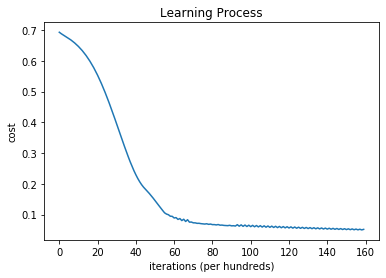

In [73]:
fitted_parameters_adam = L_model(layer_dims=[X_train.shape[0],20,7,1], X=X_train, Y=y_train, 
                            number_of_iterations=160, learning_rate = 0.01)  

### Finalmente, se puede observar las métricas. 
##### Este modelo es competitivo también

matriz de confusión
[[21677   419]
 [   12  1759]]
accuracy
0.9819415929945112
precision
0.8076216712580349
recall
0.9932241671372106
f1
0.8908584451759939
AUC
0.987130729477367


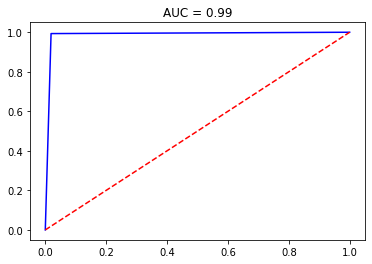

In [74]:
y_pred=predict(X_test, fitted_parameters_adam) 
saca_metricas(y_test[0], y_pred[0]) 

In [75]:
def predict_proba(X, parameters):
    forward_param={}
    A_prev=X
    layers=int(len(parameters)/2) 
    for l in range(1,layers): 
        forward_param['Z'+str(l)]=np.dot(parameters['W'+str(l)], A_prev)+parameters['b'+str(l)] 
        forward_param['A'+str(l)]=np.maximum(0, forward_param['Z'+str(l)]) #ReLU activation function
        A_prev=forward_param['A'+str(l)]

    #Last layer
    forward_param['Z'+str(layers)]=np.dot(parameters['W'+str(layers)], 
                                          A_prev)+parameters['b'+str(layers)]    
    forward_param['A'+str(layers)]=1/(1+np.exp(-(forward_param['Z'+str(layers)])))  
    
    AL=forward_param['A'+str(int(len(parameters)/2))].reshape(1,-1)

    return np.array(AL)

In [76]:
data_enero=dataset.loc[dataset['Mes_del_dataset']=='Enero',list(pd.DataFrame(dataset.columns).apply(lambda x: x[0] not in ['Mes_del_dataset'], axis=1))] 
X_test_enero=data_enero.loc[:,list(pd.DataFrame(data_enero.columns).apply(lambda x: x[0] not in ['¿Abandona?'], axis=1))]
scaler = MinMaxScaler()    
X_test_enero=scaler.fit_transform(X_test_enero) 
X=np.array(X_test_enero).T

print('================================================================')
print('Predicción de los clientes que se van a marchar en Febrero: \nsi es "1" cliente abadona, "0" si continúa')
print('================================================================') 
print()
print('X_test_enero shape: {}'.format(X_test_enero.shape))
print() 
y_pred_Enero=predict(X, fitted_parameters_adam)

print('number of ones: {}'.format(len(y_pred_Enero[y_pred_Enero==1]))) 
print('number of zeros: {}'.format(len(y_pred_Enero[y_pred_Enero==0]))) 
print('ratio of ones: {}%'.format(round((len(y_pred_Enero[y_pred_Enero==1])/len(y_pred_Enero[0]))*100,3)))    
print()
print(pd.DataFrame(y_pred_Enero[0], index=data_enero.index) )

y_pred_proba_Enero=predict_proba(X, fitted_parameters_adam)
print()
print()
print() 
print('================================================================') 
print('probabilities')
print('================================================================') 
probs=pd.DataFrame({'probability':y_pred_proba_Enero[0]}, index=data_enero.index) 
probs
# probs.columns=['prob de NO abandonar ("¿Abandona?"=0)', 'prob de abandonar ("¿Abandona?"=1)']
# pd.DataFrame(probs) 

Predicción de los clientes que se van a marchar en Febrero: 
si es "1" cliente abadona, "0" si continúa

X_test_enero shape: (92711, 5)

number of ones: 1960
number of zeros: 90751
ratio of ones: 2.114%

          0
id         
1       0.0
2       0.0
3       0.0
4       0.0
6       0.0
...     ...
99996   0.0
99997   0.0
99998   0.0
99999   0.0
100000  0.0

[92711 rows x 1 columns]



probabilities


,probability
id,
1,0.000587
2,0.000384
3,0.000384
4,0.000587
6,0.023619
...,...
99996,0.000003
99997,0.003090
99998,0.000587


#### GridSearch manual para mejorar la red neuronal

In [89]:
import itertools
def expandgrid(*itrs):
   product = list(itertools.product(*itrs))
   return {'Var{}'.format(i+1):[x[i] for x in product] for i in range(len(itrs))}

# a = [1,2,3]
# b = [5,7,9]
# pd.DataFrame(expandgrid(a, b)) 

learning_rate = np.linspace(0.005,0.02,4) 
layer_dims    = [[X_train.shape[0],7,1], [X_train.shape[0],20,7,1], [X_train.shape[0],50,20,7,1]]

grid=pd.DataFrame(expandgrid(learning_rate, layer_dims))
grid.columns= ['learning_rate', 'layer_dims']
grid

,learning_rate,layer_dims
0,0.005,"[5, 7, 1]"
1,0.005,"[5, 20, 7, 1]"
2,0.005,"[5, 50, 20, 7, 1]"
3,0.010,"[5, 7, 1]"
4,0.010,"[5, 20, 7, 1]"
5,0.010,"[5, 50, 20, 7, 1]"
6,0.015,"[5, 7, 1]"
7,0.015,"[5, 20, 7, 1]"
8,0.015,"[5, 50, 20, 7, 1]"
9,0.020,"[5, 7, 1]"


### Pongo en comentario la gráfica de aprendizaje y los costes por iteración

In [91]:
def L_model(layer_dims, X, Y, number_of_iterations, learning_rate, update_method='adam'):
    layer_dims=layer_dims
    previous_parameters = initialization(layer_dims)
    values=[]
    t=0
    np.random.seed(6666)
    
    for i in range(number_of_iterations):
        loss, forward_param, previous_parameters = forward_propagation_AND_cost_computation(X, Y, previous_parameters)  
        
        values.append(loss)
        
        grads = backward_propagation(X, Y, previous_parameters)
#         if i%30==0:
#             print('iteration {}, cost: {}'.format(i,loss)) 
#             print(forward_param['A'+str(int(len(layer_dims)-1))]) 

#         previous_parameters = gradient_update(previous_parameters, grads)
        if update_method=='adam':
            v,s = initialize_adam(previous_parameters)
            t = t + 1 # Adam counter
            previous_parameters=update_parameters_with_adam(previous_parameters, grads, v, s, t, learning_rate) 
        else:
            previous_parameters = gradient_update(previous_parameters, grads, learning_rate) 
         
    y=Y
    y_hat=forward_param['A'+str(int(len(previous_parameters)/2))] 
    
    accuracy=np.array(y==np.array(y_hat>0.5, dtype=float), dtype=float)

#     print('\n\n accuracy train: {}'.format(round(np.sum(accuracy)/len(accuracy[0]),8)))   
    
#     plt.plot(np.squeeze(values))  
#     plt.ylabel('cost')
#     plt.xlabel('iterations (per hundreds)')
#     plt.title("Learning Process")
#     plt.show() 
    return previous_parameters

In [99]:
dict_values={}
for i in range(len(grid)):
    learning_rate = grid.iloc[i,0]
    layer_dims    = grid.iloc[i,1]

    fitted_parameters_adam = L_model(layer_dims=layer_dims, X=X_train, Y=y_train, 
                                     number_of_iterations=160, learning_rate = learning_rate)  
    
    y_pred=predict(X_test, fitted_parameters_adam) 
    dict_values[i]=learning_rate, layer_dims, accuracy_score(y_test[0], y_pred[0])
    print(dict_values[i]) 

(0.005, [5, 7, 1], 0.98189969413835)
(0.005, [5, 20, 7, 1], 0.9819415929945112)
(0.005, [5, 50, 20, 7, 1], 0.9819415929945112)
(0.01, [5, 7, 1], 0.9819415929945112)
(0.01, [5, 20, 7, 1], 0.9819415929945112)
(0.01, [5, 50, 20, 7, 1], 0.9819415929945112)
(0.015, [5, 7, 1], 0.9819415929945112)
(0.015, [5, 20, 7, 1], 0.9819415929945112)
(0.015, [5, 50, 20, 7, 1], 0.9819415929945112)
(0.02, [5, 7, 1], 0.9819415929945112)
(0.02, [5, 20, 7, 1], 0.9819415929945112)
(0.02, [5, 50, 20, 7, 1], 0.9785477856454519)


In [100]:
table=pd.DataFrame(dict_values).T 
table.columns=['learning_rate', 'layer_dims', 'accuracy_score(test)']
table

,learning_rate,layer_dims,accuracy_score(test)
0,0.005,"[5, 7, 1]",0.9819
1,0.005,"[5, 20, 7, 1]",0.981942
2,0.005,"[5, 50, 20, 7, 1]",0.981942
3,0.01,"[5, 7, 1]",0.981942
4,0.01,"[5, 20, 7, 1]",0.981942
5,0.01,"[5, 50, 20, 7, 1]",0.981942
6,0.015,"[5, 7, 1]",0.981942
7,0.015,"[5, 20, 7, 1]",0.981942
8,0.015,"[5, 50, 20, 7, 1]",0.981942
9,0.02,"[5, 7, 1]",0.981942


###### En este caso, no he conseguido mejorar la accuracy, solo consiguo igualar el resultado.

A continuación, se muestran todas las combinaciones de hiperparámetros que igualan el accuracy del primer modelo de red neuronal

In [103]:
table.loc[table['accuracy_score(test)'] == 0.9819415929945112, :] 

,learning_rate,layer_dims,accuracy_score(test)
1,0.005,"[5, 20, 7, 1]",0.981942
2,0.005,"[5, 50, 20, 7, 1]",0.981942
3,0.01,"[5, 7, 1]",0.981942
4,0.01,"[5, 20, 7, 1]",0.981942
5,0.01,"[5, 50, 20, 7, 1]",0.981942
6,0.015,"[5, 7, 1]",0.981942
7,0.015,"[5, 20, 7, 1]",0.981942
8,0.015,"[5, 50, 20, 7, 1]",0.981942
9,0.02,"[5, 7, 1]",0.981942
10,0.02,"[5, 20, 7, 1]",0.981942


Como se puede observar, la puntuación no ha sido mejorada

In [102]:
table.loc[table['accuracy_score(test)'] > 0.9819415929945112, :] 

,learning_rate,layer_dims,accuracy_score(test)


#### Este es el final.
###### Muchas gracias!